In [128]:
import os
import sys
import yaml
import copy
import warnings
import importlib as imp
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import pcl
import pyntcloud

sys.path.append('/home/jovyan/work/obstacle-detection/')

In [118]:
with open('../config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [139]:
# Segments id -> name mapping
seg_lst = config['segments']
# seg_lst

In [125]:
# Obstacles id -> name mapping
obstacle_lst = config['obstacles']
obstacle_lst

{10: 'car',
 11: 'bicycle',
 13: 'bus',
 15: 'motorcycle',
 16: 'on-rails',
 18: 'truck',
 20: 'other-vehicle',
 30: 'person',
 31: 'bicyclist',
 32: 'motorcyclist',
 252: 'moving-car',
 253: 'moving-bicyclist',
 254: 'moving-person',
 255: 'moving-motorcyclist',
 256: 'moving-on-rails',
 257: 'moving-bus',
 258: 'moving-truck',
 259: 'moving-other-vehicle'}

In [136]:
num ='066'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

In [147]:
label = [seg & 0xFFFF for seg in label]
unq = list(set(label))
print('Scan have:')
for seg in unq:
    if seg in list(seg_lst.keys()):
        print(seg, seg_lst[seg])

Scan have:
0 unlabeled
1 outlier
99 other-object
70 vegetation
71 trunk
40 road
72 terrain
10 car
11 bicycle
44 parking
80 pole
81 traffic-sign
50 building
51 fence
48 sidewalk
20 other-vehicle
60 lane-marking
253 moving-bicyclist


In [165]:
# pcloud = pyntcloud.PyntCloud(pcloud)

In [261]:
# pcloud = pd.DataFrame(scan, columns=['x', 'y', 'z'])
# test_cloud.plot(use_as_color='seg_id', cmap="cool")

In [166]:
# pcloud.plot(use_as_color='camera', cmap="cool")

In [294]:
# is_parking = ~test_cloud.points['seg_id'].isin(list(obstacle_lst.keys()))
# test_cloud.points['is_parking'] = pd.Series(is_parking)

In [167]:
# test_cloud.plot(use_as_color='is_parking', cmap="RdYlGn", output_name="is_parking")

In [168]:
# is_parking = test_cloud.points['is_parking'] != 1
# test_cloud.apply_filter(is_parking)

In [169]:
# test_cloud.plot()

In [90]:
# n_voxels = 45
# voxelgrid_id = test_cloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=10)

In [170]:
# %time cluster_id = test_cloud.add_scalar_field("euclidean_clusters",voxelgrid_id=voxelgrid_id)

In [171]:
# test_cloud.plot(use_as_color=cluster_id, cmap="cool")

In [676]:
from pipeline import common
common = imp.reload(common)

In [762]:
def pipeline_optimized(scan, label, obstacle_lst, verbose=False, exec_time=False, **params):
    
    # ROI filter 
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
    
    pcloud = common.roi_filter(pcloud,  min_x=-5, max_x=45, 
                                        min_y=-22,max_y=22,
                                        min_z=-1.5, max_z=2, verbose=False)
    roi_time = datetime.now() - start_time
    
    # get segment id
    start_time = datetime.now()
    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    pcloud = pyntcloud.PyntCloud(pcloud)
    obstacle_time = datetime.now() - start_time
    
    
    # get voxel grid
    start_time = datetime.now()
    voxelgrid_id = pcloud.add_structure("voxelgrid", n_x=params['x_voxels'], 
                                                     n_y=params['y_voxels'],
                                                     n_z=params['z_voxels'])
    voxel_time = datetime.now() - start_time
    
    
    # get cluster
    start_time = datetime.now()
    cluster_id = pcloud.add_scalar_field("euclidean_clusters", voxelgrid_id=voxelgrid_id)
    cluster_time = datetime.now() - start_time

    
    # get cluster min max
    start_time = datetime.now()
#     clusters = pcloud.points.groupby([cluster_id]).agg({ 'x':['min','max'],
#                                                          'y':['min','max'],
#                                                          'z':['min','max'] })
    clusters = []
    for _id in pcloud.points[cluster_id].unique():
        tcluster = common.outlier_filter(pcloud.points[pcloud.points[cluster_id] == _id])
        min_max = tcluster.groupby(['seg_id']).agg({   'x': ['min', 'max'],
                                                       'y': ['min', 'max'],
                                                       'z': ['min', 'max'] })
        clusters.append(min_max.values)
    min_max_time = datetime.now() - start_time
    
    
    cluster_data = pcloud.points[['x', 'y', 'z', cluster_id]].rename(columns ={cluster_id: 'cluster_id'})
    if verbose:
        print('Execution time:')
        print('\n - ROI filtering: {:.0f} ms'.format(roi_time.microseconds / 1000))
        print('\n - Filtering obstacles: {:.0f} ms'.format(obstacle_time.microseconds / 1000))
        print('\n - Voxel grid: {:.0f} ms'.format(voxel_time.microseconds / 1000))
        print('\n - Clustering: {:.0f} ms'.format(cluster_time.microseconds / 1000))
        print('\n - Min-max cluster points: {:.0f} ms \n'.format(min_max_time.microseconds / 1000))
        
    if exec_time:
        return clusters, cluster_data, {'roi_time': roi_time.microseconds / 1000,
                                        'filter_obstacle_time': obstacle_time.microseconds / 1000,
                                        'voxel_grid_time': voxel_time.microseconds / 1000,
                                        'clustering_time': cluster_time.microseconds / 1000,
                                        'outlier_filter_bbox_time': min_max_time.microseconds / 1000}
    else:
        return clusters, cluster_data

## Pipeline implementation

In [760]:
%time 
num='020'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:,:3]

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs


In [761]:
%%time
clusters, cluster_data = pipeline_optimized(scan, label, obstacle_lst, verbose=True, 
                                                                       x_voxels=25,
                                                                       y_voxels=20,
                                                                       z_voxels=5)

Execution time:

 - ROI filtering: 25 ms

 - Filtering obstacles: 45 ms

 - Voxel grid: 1 ms

 - Clustering: 44 ms

 - Min-max cluster points: 111 ms 

CPU times: user 222 ms, sys: 1.07 ms, total: 223 ms
Wall time: 229 ms


In [755]:
records = []
for x in clusters:
    for y in x:
        records.append(y)

In [667]:
rec = pd.DataFrame.from_records(records)

In [638]:
%time box_coord_list = get_bounding_boxes(rec)
print('It is {} clusters'.format(len(box_coord_list)))

CPU times: user 5.41 ms, sys: 2.02 ms, total: 7.42 ms
Wall time: 10.4 ms
It is 12 clusters


In [639]:
# %time box_coord_list = common.get_optimal_bboxes(clusters, cluster_data)
# print(len(box_coord_list))

In [640]:
test_cloud = pyntcloud.PyntCloud(cluster_data)
test_cloud.plot(use_as_color='cluster_id', cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(2.203431591615027, 11.196428901660202, -0.77…

In [262]:
# cluster_data

In [641]:
from scripts import draw
draw = imp.reload(draw)

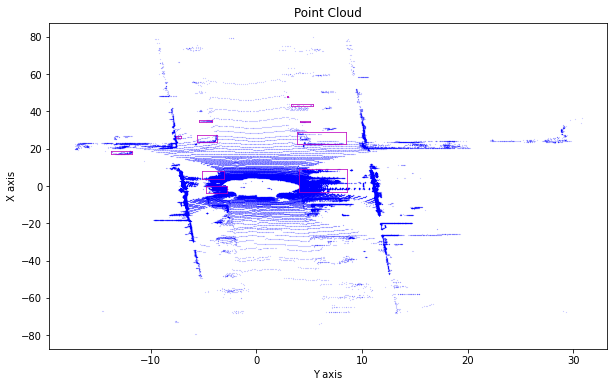

In [642]:
%matplotlib inline
f = plt.figure(figsize=(10, 6))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [643]:
pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
%time cloud = common.obstacle_filter(pcloud, obstacle_lst)

Filter required segments
Point size before: 117412 and after filtering: 20347
CPU times: user 228 ms, sys: 937 µs, total: 229 ms
Wall time: 231 ms


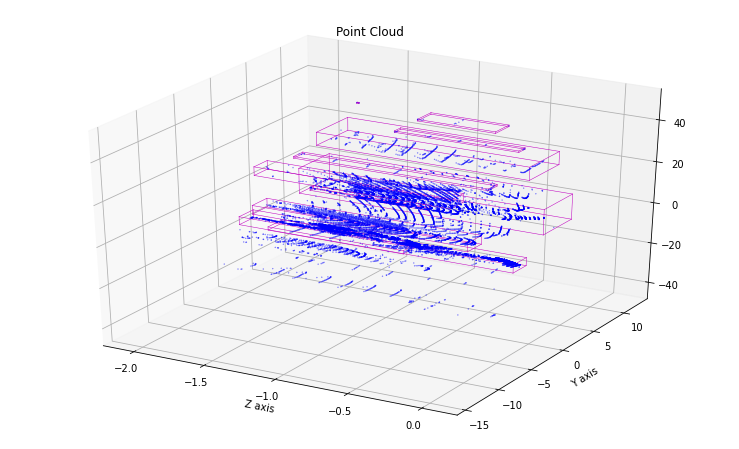

In [646]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [2,1,0]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

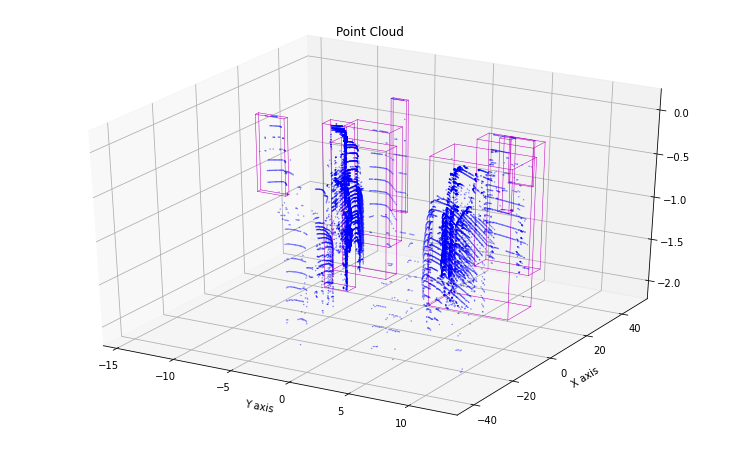

In [580]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [1,0,2]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

## Getting bounding boxes for sequence 00

In [788]:
import glob
scan_lst = sorted(glob.glob("../dataset/sequences/00/velodyne/*.bin"))
labels_lst = sorted(glob.glob("../dataset/sequences/00/labels/*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))


READ OK, number of scans  459


In [795]:
from scripts import test
test = imp.reload(test)

In [796]:
help(test.get_bbox_and_stat)

Help on function get_bbox_and_stat in module scripts.test:

get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst, pipeline, write_path=None, detailed=False, **pipeline_params)
    Gettitng bounding boxes for reqired sequence of scans and labels
    Also ability to grep time execution statistic.
    
    scan_lst: list,
    A list of LIDAR scans
    
    labels_lst: list,
    A list of labels respectively
    
    obstacle_lst: list,
    A list of obstacles id
    
    pipeline: function,
    An obstacle-detection pipeline function with required args
    
    write_path: string, optional, default None
    A path where to write labels. If None labels will not be recorded
    
    detailed: bool, optional, default False
    If True there will be time execution statistic returned



In [782]:
%%time
n_scan = -1
# write_path = '../dataset/sequences/00/velodyne/000355.bin'
bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst[:n_scan], labels_lst[:n_scan], obstacle_lst,
                                                 pipeline_optimized, 
                                                 write_path=None, detailed=True,
                                                                         x_voxels=25,
                                                                         y_voxels=20,
                                                                         z_voxels=5)


CPU times: user 5min 37s, sys: 3.73 s, total: 5min 40s
Wall time: 6min 7s


In [783]:
steps = list(stats[0].keys())
steps_exec_time = []
for step in steps:
    steps_exec_time.append([stat[step] for stat in stats])

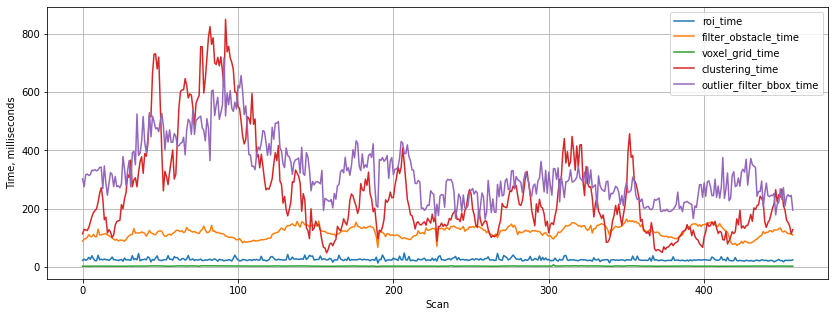

In [784]:
plt.figure(figsize=(14,5))
for i, step in enumerate(steps):
    plt.plot(steps_exec_time[i], label=step)
plt.legend(loc='best')
plt.xlabel('Scan')
plt.ylabel('Time, milliseconds')
plt.grid()
plt.show()

In [785]:
time_stat = list(exec_time_dct.values())
print('Min process time {} ms'.format(min(time_stat)))
print('Mean process time {} ms'.format(np.mean(time_stat)))
print('Max process time {} ms'.format(max(time_stat)))

Min process time 6.547 ms
Mean process time 595.2891244541485 ms
Max process time 992.954 ms


In [786]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = time_stat

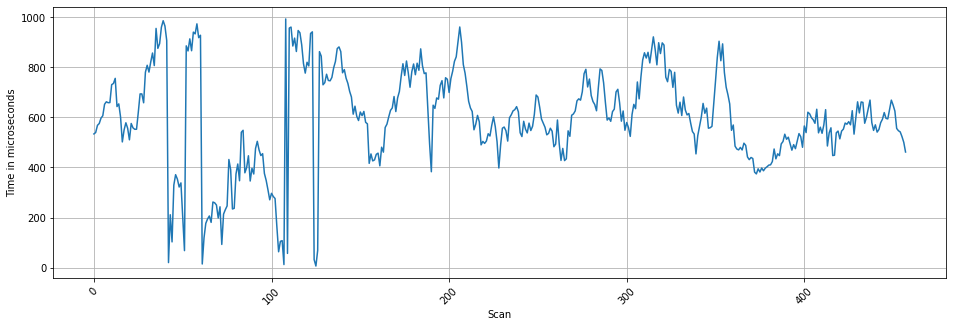

In [787]:
plt.figure(figsize=(16, 5))
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time in microseconds')
plt.grid()
plt.xticks(rotation=45)
plt.show()

### Grep statistics of execution time

In [442]:
exec_lst = []
n_epoch = 3
for i in range(n_epoch):
    _, exec_time_dct = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                              pipeline_optimized, write_path=None,
                                                                  x_voxels=25,
                                                                  y_voxels=20,
                                                                  z_voxels=5)
    exec_lst.append(exec_time_dct)

In [452]:
several_exec_time_lst = [] 
for epoch in exec_lst:
    several_exec_time_lst.append([tdelta.microseconds for tdelta in epoch.values()])
several_exec_time_lst = list(zip(several_exec_time_lst[0],
                                 several_exec_time_lst[1],
                                 several_exec_time_lst[2]))

In [454]:
several_exec_time_lst[:3]

[(387403, 382174, 361611), (418736, 408954, 395278), (383912, 373594, 357415)]

In [457]:
oy_mean = [np.mean(exec_times) for exec_times in several_exec_time_lst]
oy_min = [min(exec_times) for exec_times in several_exec_time_lst]
oy_max = [max(exec_times) for exec_times in several_exec_time_lst]

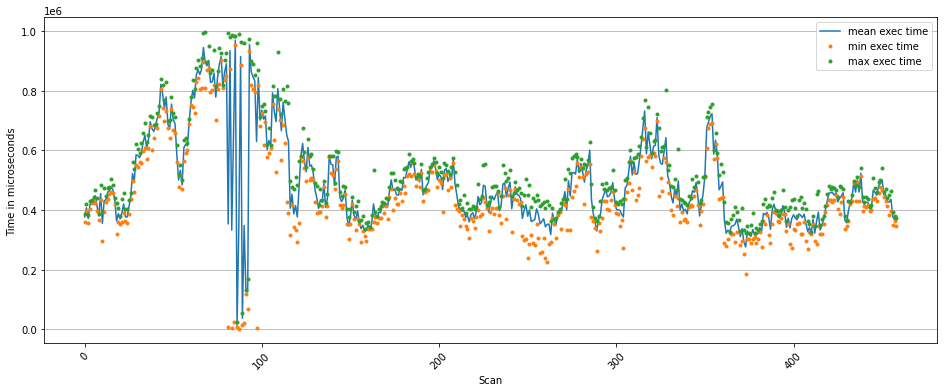

In [464]:
plt.figure(figsize=(16, 6))
plt.plot(ox, oy_mean, label='mean exec time')
plt.plot(ox, oy_min, '.', label='min exec time')
plt.plot(ox, oy_max, '.', label='max exec time')
ax = plt.axes()        
ax.yaxis.grid()
plt.xticks(rotation=45)
plt.xlabel('Scan')
plt.ylabel('Time in microseconds')
plt.legend()
plt.show()